### Notebook to check how the blob radius expands over differing Z values

- Collect some thekla files and check they're blob positions
- Take blob positions that are near the gate (Z ~ 0 mm) and further away
- Find a way to quantify blob size.
- Find out the expected diffusion in the detector (its written somewhere I'm sure)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_master/IC/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


import functions.functions_HE as func


#### Load in tracking information

In [2]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list, failures = zip(*results)

    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    # Sum up the failures
    total_failures = sum(failures)

    return tracks, total_failures


In [3]:
MC = False     # this defines whether is MC or not
data_path = 'data'

#data_path = 'data' 
                   # this defines where the thekla files are located
                   # data or scratch

if MC:
    DATA_PATH = 'N100_LPR_MC'
else:
    DATA_PATH = 'N100_LPR'

#RUN_NUMBERS = [15116, 15152, 15153]
#TIMESTAMPS  = ['240625', '230625', '220625']


RUN_NUMBERS = ['15589']
TIMESTAMPS  = ['456018']

#RUN_NUMBERS = [15589, 15590, 15591, 15592]
#TIMESTAMPS  = ['355021'] # compare to 557018, and 658021


RUN_NUMBER = "_".join(map(str, RUN_NUMBERS))
TIMESTAMP = "_".join(map(str, TIMESTAMPS))
CITY = 'thekla'
print(RUN_NUMBER, TIMESTAMP)


15589 456018


In [4]:
# if multiple files use this one
hdst = []
errors = 0
for q, (RN, TS) in enumerate(zip(RUN_NUMBERS, TIMESTAMPS)):
    print(f'R-{RN}, TS-{TS}')
    # whole thing
    # scratch path (postcut)
    n100_dir = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/{CITY}/{TS}/'
    print(n100_dir)

    for i in tqdm(range(1,8)):
        print(f"LDC {i}")
        folder_path = n100_dir + 'ldc' + str(i) + '/'
        holder, err = load_data_fast(folder_path)
        r = holder
        errors += err
        r['event'] *= 1/(q+1)
        hdst.append(r)

hdst = pd.concat(hdst)

print(f'Number of failed files: {errors}')

R-15589, TS-456018
/data/halmazan/NEXT/N100_LPR/15589/thekla/456018/


  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

LDC 1
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_0145_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_5323_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_0566_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_4746_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_1189_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_0161_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 14%|█████████████████████████▏                                                                                                                                                      | 1/7 [01:07<06:43, 67.17s/it]

LDC 2
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_3238_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_5189_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_4519_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_5205_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_3926_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_1201_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 29%|██████████████████████████████████████████████████▎                                                                                                                             | 2/7 [02:16<05:41, 68.36s/it]

LDC 3
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_0930_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_4349_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_1088_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_4247_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_0555_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_3006_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Trac

 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 3/7 [03:30<04:43, 70.81s/it]

LDC 4
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_1850_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_2806_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_4085_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_3002_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_3284_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_0844_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Trac

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 4/7 [04:39<03:31, 70.39s/it]

LDC 5
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_0798_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_0130_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_3823_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_0842_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_4527_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_3538_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 5/7 [05:49<02:20, 70.21s/it]

LDC 6
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_4361_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_0545_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_2201_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_1967_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_0704_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_1650_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6/7 [06:59<01:10, 70.04s/it]

LDC 7
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_2706_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_4607_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_2072_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_1827_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_0581_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_1356_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [08:08<00:00, 69.83s/it]

Number of failed files: 194


### Plot the blob positions across the volume

In [5]:
hdst.columns.values

array(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min',
       'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave',
       'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z',
       'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y',
       'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2',
       'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z'],
      dtype=object)

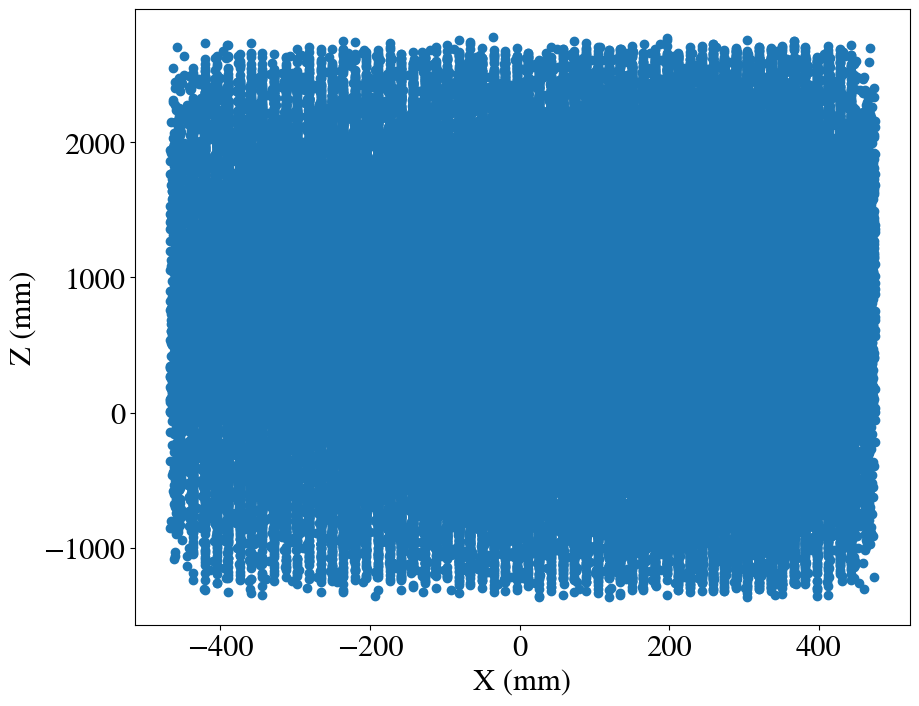

In [6]:
plt.scatter(hdst.blob1_x, hdst.blob1_z)
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.show()

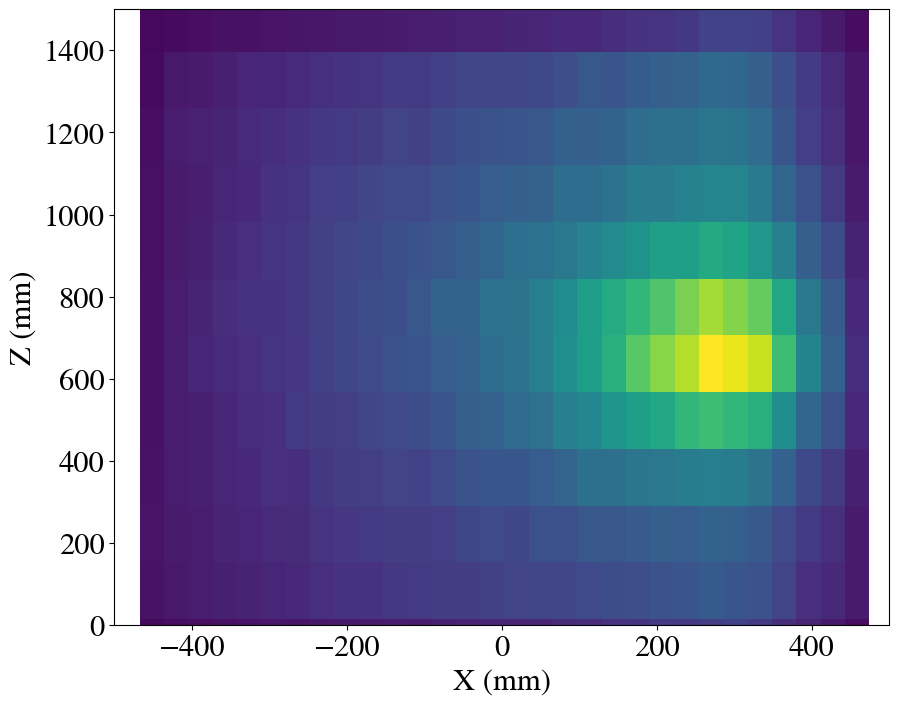

In [7]:
plt.hist2d(hdst.blob1_x, hdst.blob1_z, bins = (30, 30))
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.xlim([-500, 500])
plt.ylim([0, 1500])
plt.show()

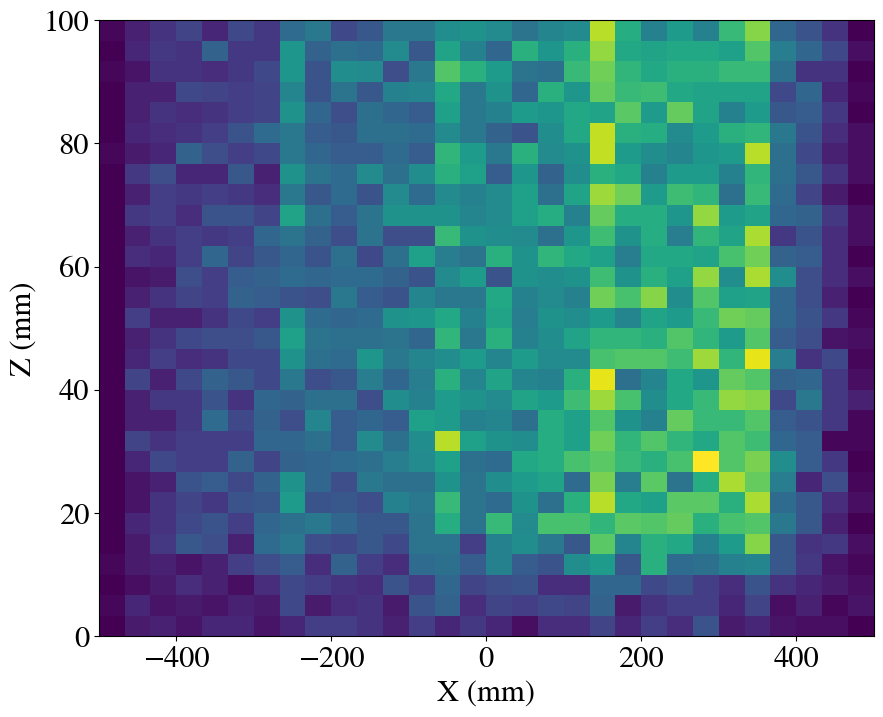

In [8]:
plt.hist2d(hdst.blob1_x, hdst.blob1_z, bins = (30, 30), range = [[-500, 500], [0, 100]])
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.show()

In [9]:
# only collect good events
low_z = 20
upp_z  = 1195
r_lim = 450
low_e = 1.4
upp_e = 1.8
cut_hdst, efficiencies = func.apply_cuts(hdst, 
                                         lower_z = low_z, 
                                         upper_z = upp_z, 
                                         r_lim   = r_lim, 
                                         lower_e = low_e, 
                                         upper_e = upp_e)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 450
Fiducial track cut
Relative Cut efficiency:
Efficiency: 21.66 %
Absolute Cut efficiency:
Efficiency: 21.66 %
One track cut
Relative Cut efficiency:
Efficiency: 52.19 %
Absolute Cut efficiency:
Efficiency: 21.86 %

Blob overlap cut
Relative Cut efficiency:
Efficiency: 88.12 %
Absolute Cut efficiency:
Efficiency: 19.36 %
Energy cut
Relative Cut efficiency:
Efficiency: 88.16 %
Absolute Cut efficiency:
Efficiency: 46.39 %


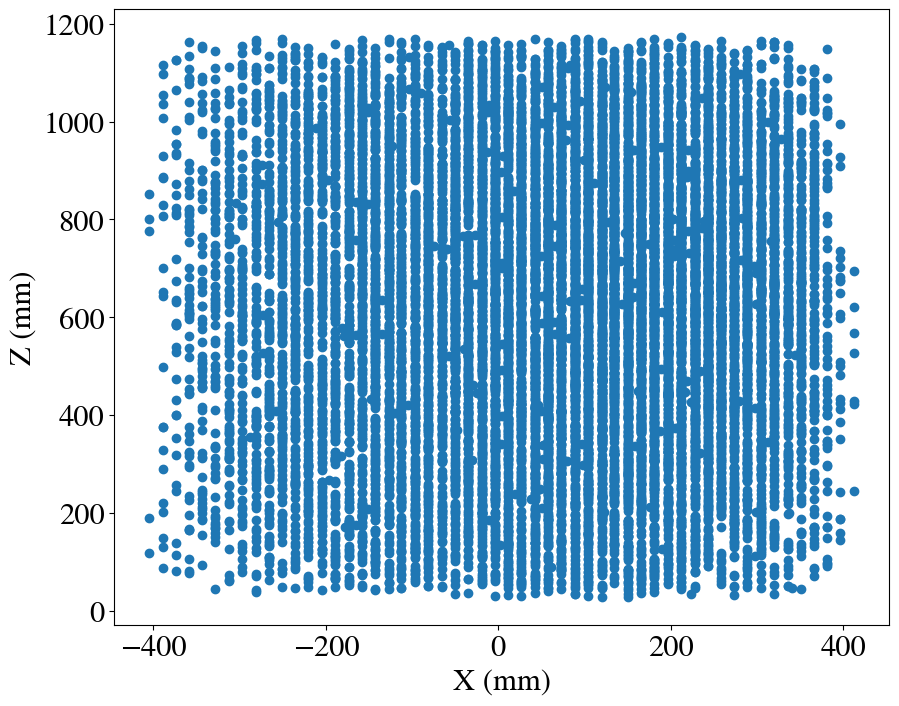

In [13]:
plt.scatter(cut_hdst.blob1_x, cut_hdst.blob1_z)
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.show()

In [14]:
# collect events at z 20, z 320, z 620, ... z 1520

def z_events(hdst, z_lower, z_upper):
    return (hdst[(hdst['blob1_z'] >= z_lower) & (hdst['blob1_z'] <= z_upper)]).event.values

events_z_20_40 = z_events(cut_hdst, 20, 40)
events_z_320_340 = z_events(cut_hdst, 320, 340)
events_z_620_640 = z_events(cut_hdst, 620, 640)
events_z_920_940 = z_events(cut_hdst, 920, 940)
events_z_1220_1240 = z_events(cut_hdst, 1220, 1240)
events_z_1520_1540 = z_events(cut_hdst, 1520, 1540)


In [16]:
display(events_z_20_40)
display(events_z_320_340)
display(events_z_620_640)
del cut_hdst
del hdst


array([2143226., 3137814., 2655892., 3191757., 3143037., 2792450.,
        473329., 2993008., 2929575., 3555516., 2420298., 3542461.,
        111250., 2522582., 2127545., 1299424.,  510230., 1333157.])

array([2899359.,  146448., 2791811., 3795380., 3296497., 1630343.,
       1648354.,  187510.,  320034., 2928500., 2086358., 1505477.,
       2058953., 3473142., 1704711., 2697038., 3722930., 2159193.,
        662845., 1471695., 1705131., 1495320., 3550527., 1898366.,
        282500., 3111578., 1610414.,  959778., 3810836., 1710242.,
       3177288., 2418243.,  813136., 1270558., 2193466., 3324491.,
        183493., 1760929., 1362538., 2908187.,   84884., 1307924.,
       1308134., 1195826., 1614909., 1178270.,  491451., 1899921.,
       2146342., 1261472., 2443604., 2932407., 3584807.,  824399.,
       1648075., 2981953.,  959219., 1176674., 3598478., 3156470.,
       1085268., 1748707.,  182751., 1014911., 2831642., 3218259.,
       1063526., 2413777.,  817469.,  756709.,   85906.,  862948.,
       3375143., 2455329., 2011557., 2526659., 1624842., 3291494.,
        436831., 3686546., 3506590., 2352101., 1242818., 1823426.,
       3524706., 1185894., 2278461., 1383042., 2146014., 35415

array([1.567308e+06, 2.947841e+06, 8.972700e+04, 2.713586e+06,
       8.089000e+05, 3.531370e+05, 1.528381e+06, 5.019800e+04,
       8.036570e+05, 3.814574e+06, 4.055600e+05, 3.239769e+06,
       2.627339e+06, 1.449939e+06, 7.205390e+05, 3.325617e+06,
       1.733649e+06, 3.771552e+06, 2.770433e+06, 2.273111e+06,
       3.085050e+05, 2.568119e+06, 1.634669e+06, 1.723933e+06,
       1.410599e+06, 2.525741e+06, 2.577002e+06, 3.705710e+06,
       1.611345e+06, 2.994930e+06, 3.942690e+05, 1.334292e+06,
       3.630705e+06, 6.998700e+04, 1.365211e+06, 2.220499e+06,
       6.255560e+05, 1.705140e+05, 1.926275e+06, 1.336238e+06,
       9.515250e+05, 1.279419e+06, 2.058449e+06, 7.292120e+05,
       1.935977e+06, 2.153208e+06, 3.417800e+06, 3.032000e+03,
       1.885822e+06, 3.435748e+06, 2.454866e+06, 1.750778e+06,
       3.188739e+06, 3.200520e+06, 1.543984e+06, 3.054185e+06,
       1.426958e+06, 1.069972e+06, 4.517600e+05, 3.349249e+06,
       3.555175e+06, 3.770943e+06, 6.306520e+05, 1.8629

NameError: name 'hdst' is not defined

### Load in hit information
Preferably only taking events that are from the arrays of interest

In [17]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'RECO', 'Events')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list, failures = zip(*results)

    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    # Sum up the failures
    total_failures = sum(failures)

    return tracks, total_failures


In [18]:
# if multiple files use this one
hdst_30   = []
hdst_630  = []
hdst_1230 = []
errors = 0
for q, (RN, TS) in enumerate(zip(RUN_NUMBERS, TIMESTAMPS)):
    print(f'R-{RN}, TS-{TS}')
    # whole thing
    # scratch path (postcut)
    n100_dir = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/{CITY}/{TS}/'
    print(n100_dir)

    for i in tqdm(range(1,8)):
        print(f"LDC {i}")
        folder_path = n100_dir + 'ldc' + str(i) + '/'
        holder, err = load_data_fast(folder_path)
        r = holder
        errors += err
        r['event'] *= 1/(q+1)
        # check if the events within r is in the lists you want.
        for evt, df in r.groupby('event'):
            if evt in events_z_20_40:
                hdst_30.append(df)
            elif evt in events_z_620_640:
                hdst_630.append(df)
            elif evt in events_z_1220_1240:
                hdst_1230.append(df)
        #hdst.append(r)
        break
hdst_30 = pd.concat(hdst_30)
hdst_630 = pd.concat(hdst_630)
hdst_1230 = pd.concat(hdst_1230)
#hdst = pd.concat(hdst)

print(f'Number of failed files: {errors}')

R-15589, TS-456018
/data/halmazan/NEXT/N100_LPR/15589/thekla/456018/


  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

LDC 1


  0%|                                                                                                                                                                                        | 0/7 [01:14<?, ?it/s]


ValueError: No objects to concatenate

In [ ]:
display(hdst_30)
display(hdst_630)
display(hdst_1230)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
9889460,2906.0,1.751990e+09,18,112.257487,171.745821,1,212.125,369.325,0.0,0.0,-562.59400,12.404579,269.717659,-1.0,0.001453,-1,-1.0
9889461,2906.0,1.751990e+09,18,112.257487,171.745821,1,227.675,369.325,0.0,0.0,-562.59400,21.585165,469.334759,-1.0,0.002551,-1,-1.0
9889462,2906.0,1.751990e+09,18,112.257487,171.745821,1,243.225,353.775,0.0,0.0,-562.59400,24.248734,527.249780,-1.0,0.002917,-1,-1.0
9889463,2906.0,1.751990e+09,18,112.257487,171.745821,1,243.225,369.325,0.0,0.0,-562.59400,18.079914,393.118705,-1.0,0.002200,-1,-1.0
9889464,2906.0,1.751990e+09,18,112.257487,171.745821,1,243.225,383.875,0.0,0.0,-562.59400,19.125229,415.847397,-1.0,0.002391,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6777530,3838766.0,1.752076e+09,47,-34.244545,86.526699,1,-173.625,399.425,0.0,0.0,2351.64075,21.910254,152.809660,-1.0,0.000976,-1,-1.0
6777531,3838766.0,1.752076e+09,47,-34.244545,86.526699,1,-173.625,414.975,0.0,0.0,2351.64075,11.659855,81.319847,-1.0,0.000722,-1,-1.0
6777532,3838766.0,1.752076e+09,47,-34.244545,86.526699,1,-173.625,430.525,0.0,0.0,2351.64075,11.293476,78.764595,-1.0,0.000598,-1,-1.0
6777533,3838766.0,1.752076e+09,47,-34.244545,86.526699,1,-204.725,399.425,0.0,0.0,2356.34875,19.999662,46.875918,-1.0,0.000342,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
15779197,3032.0,1.751990e+09,27,101.250656,121.565336,1,165.475,199.275,0.0,0.0,600.081375,10.954465,215.058007,-1.0,0.001057,-1,-1.0
15779198,3032.0,1.751990e+09,27,101.250656,121.565336,1,181.025,199.275,0.0,0.0,600.081375,12.914655,253.540445,-1.0,0.001251,-1,-1.0
15779199,3032.0,1.751990e+09,27,101.250656,121.565336,1,196.575,245.925,0.0,0.0,600.081375,12.437811,244.179049,-1.0,0.001255,-1,-1.0
15779200,3032.0,1.751990e+09,27,101.250656,121.565336,1,212.125,245.925,0.0,0.0,600.081375,11.628748,228.295528,-1.0,0.001186,-1,-1.0
15779201,3032.0,1.751990e+09,27,101.250656,121.565336,1,227.675,245.925,0.0,0.0,600.081375,12.923632,253.716680,-1.0,0.001328,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14534038,3843106.0,1.752077e+09,47,36.658827,-52.185116,1,165.475,-186.475,0.0,0.0,2087.973500,20.191881,528.707637,-1.0,0.002657,-1,-1.0
14534039,3843106.0,1.752077e+09,47,36.658827,-52.185116,1,165.475,-170.925,0.0,0.0,2087.973500,22.578331,591.194843,-1.0,0.002962,-1,-1.0
14534040,3843106.0,1.752077e+09,47,36.658827,-52.185116,1,149.925,-170.925,0.0,0.0,2091.932250,12.774182,375.325716,-1.0,0.001893,-1,-1.0
14534041,3843106.0,1.752077e+09,47,36.658827,-52.185116,1,149.925,-155.375,0.0,0.0,2091.932250,10.259350,301.435953,-1.0,0.001518,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
4214873,1765.0,1.751990e+09,5,13.859364,161.028365,1,-3.575,338.225,0.0,0.0,-71.169938,10.649877,396.429475,-1.0,0.001994,-1,-1.0
4214874,1765.0,1.751990e+09,5,13.859364,161.028365,1,10.975,353.775,0.0,0.0,-71.169938,12.350693,459.740410,-1.0,0.002354,-1,-1.0
4214875,1765.0,1.751990e+09,5,13.859364,161.028365,1,10.975,369.325,0.0,0.0,-71.169938,13.476936,501.663540,-1.0,0.002621,-1,-1.0
4214876,1765.0,1.751990e+09,5,13.859364,161.028365,1,26.525,353.775,0.0,0.0,-71.169938,12.934482,481.471283,-1.0,0.002442,-1,-1.0
4214877,1765.0,1.751990e+09,5,13.859364,161.028365,1,-3.575,338.225,0.0,0.0,-67.288391,12.814962,216.424083,-1.0,0.001089,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13884116,3846641.0,1.752077e+09,27,64.586072,-119.319185,1,196.575,-309.875,0.0,0.0,1434.228000,14.504109,133.088990,-1.0,0.000694,-1,-1.0
13884117,3846641.0,1.752077e+09,27,64.586072,-119.319185,1,196.575,-294.325,0.0,0.0,1434.228000,13.561541,124.440026,-1.0,0.000645,-1,-1.0
13884118,3846641.0,1.752077e+09,27,64.586072,-119.319185,1,165.475,-340.975,0.0,0.0,1438.128625,10.335213,237.036371,-1.0,0.001272,-1,-1.0
13884119,3846641.0,1.752077e+09,27,64.586072,-119.319185,1,165.475,-325.425,0.0,0.0,1438.128625,11.804065,270.724246,-1.0,0.001429,-1,-1.0


# compare some of the blob radii

EVENT 2906.0
Total energy 1.51 MeV



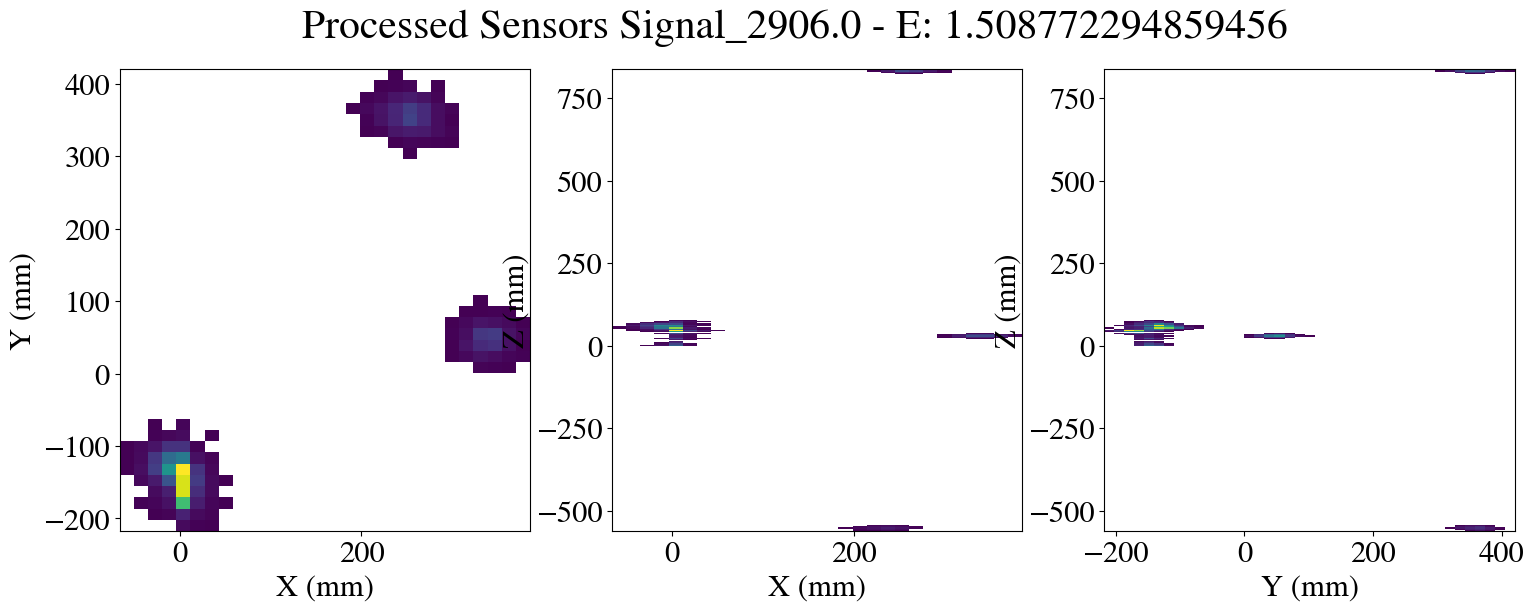

EVENT 17907.0
Total energy 1.80 MeV



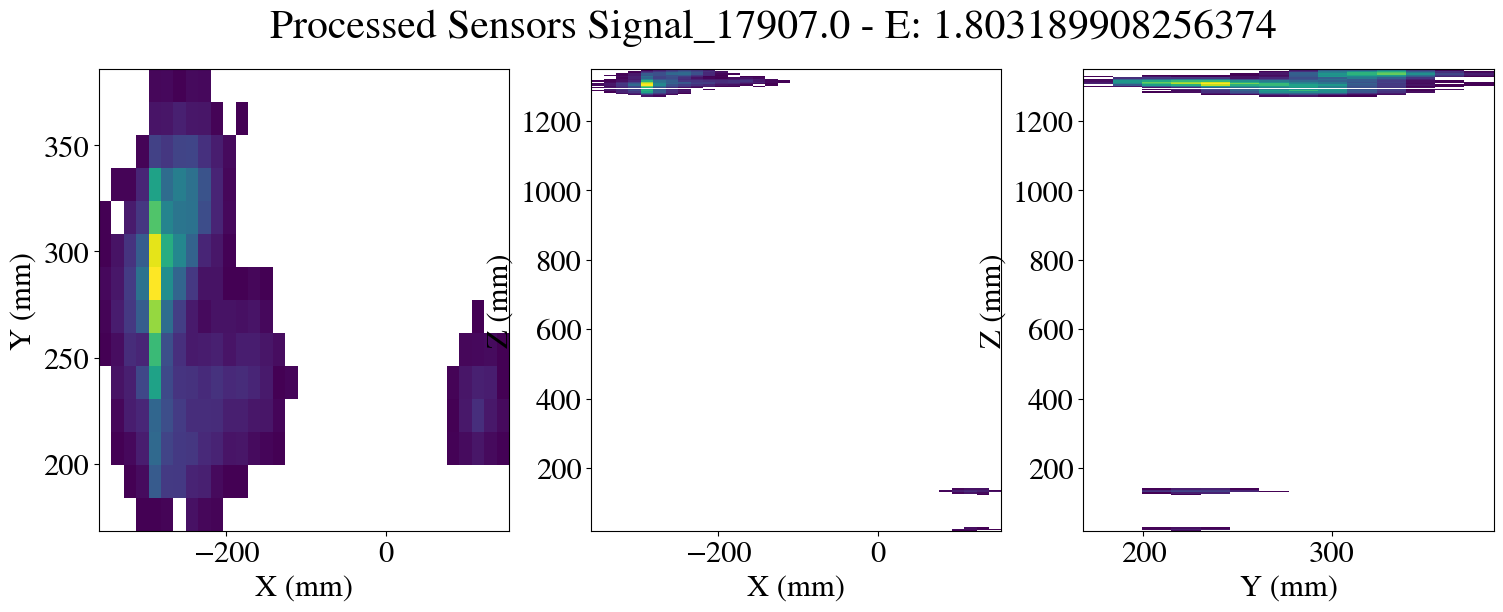

EVENT 19832.0
Total energy 1.80 MeV



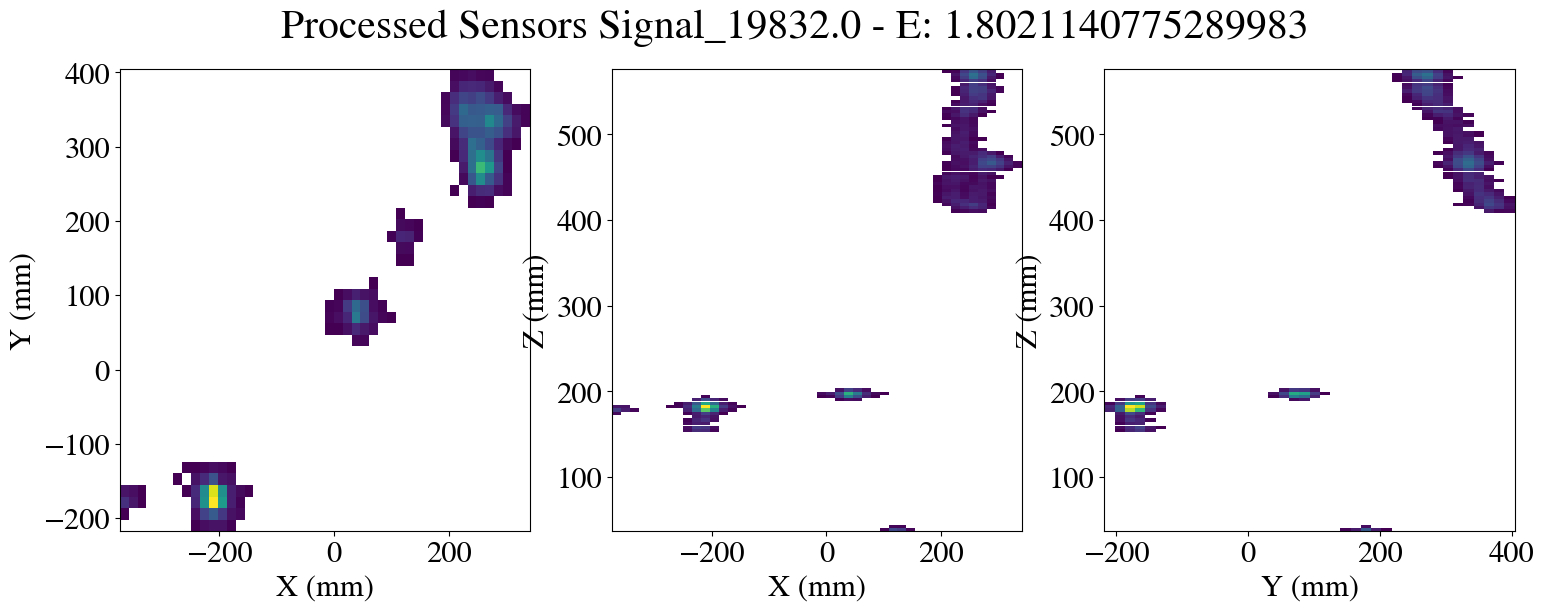

EVENT 22772.0
Total energy 1.45 MeV



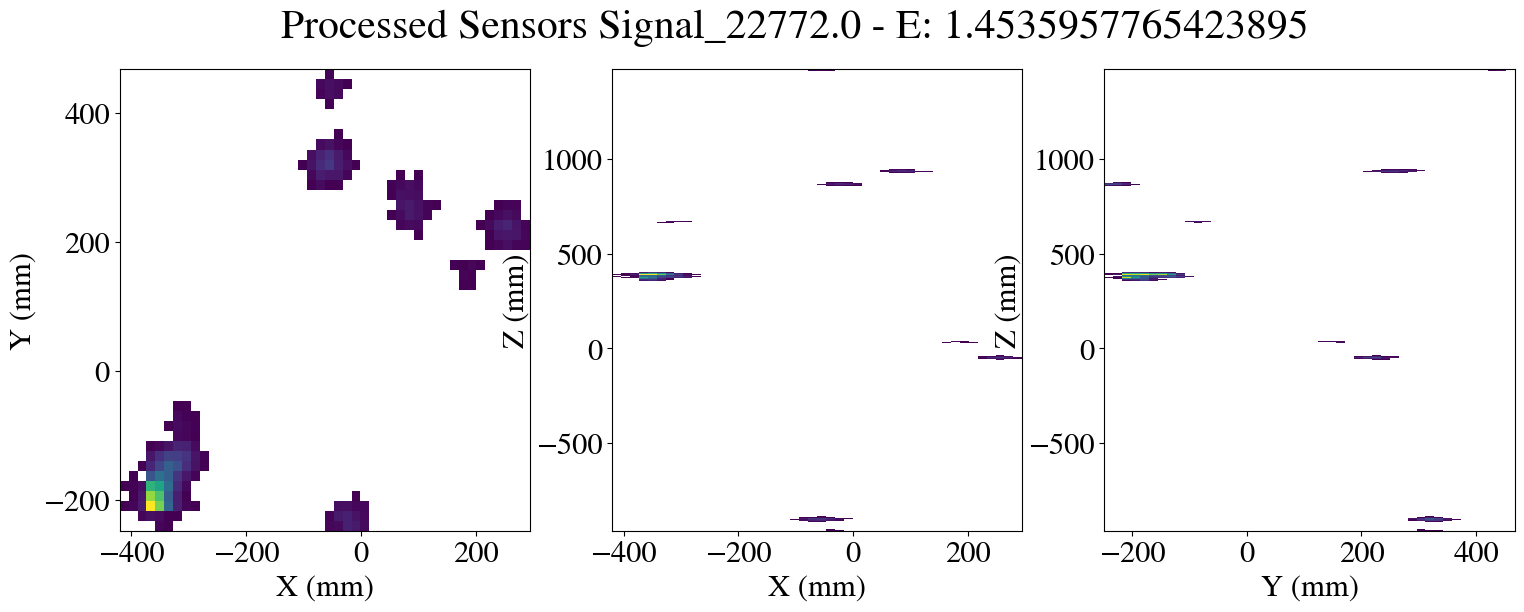

EVENT 53369.0
Total energy 1.37 MeV



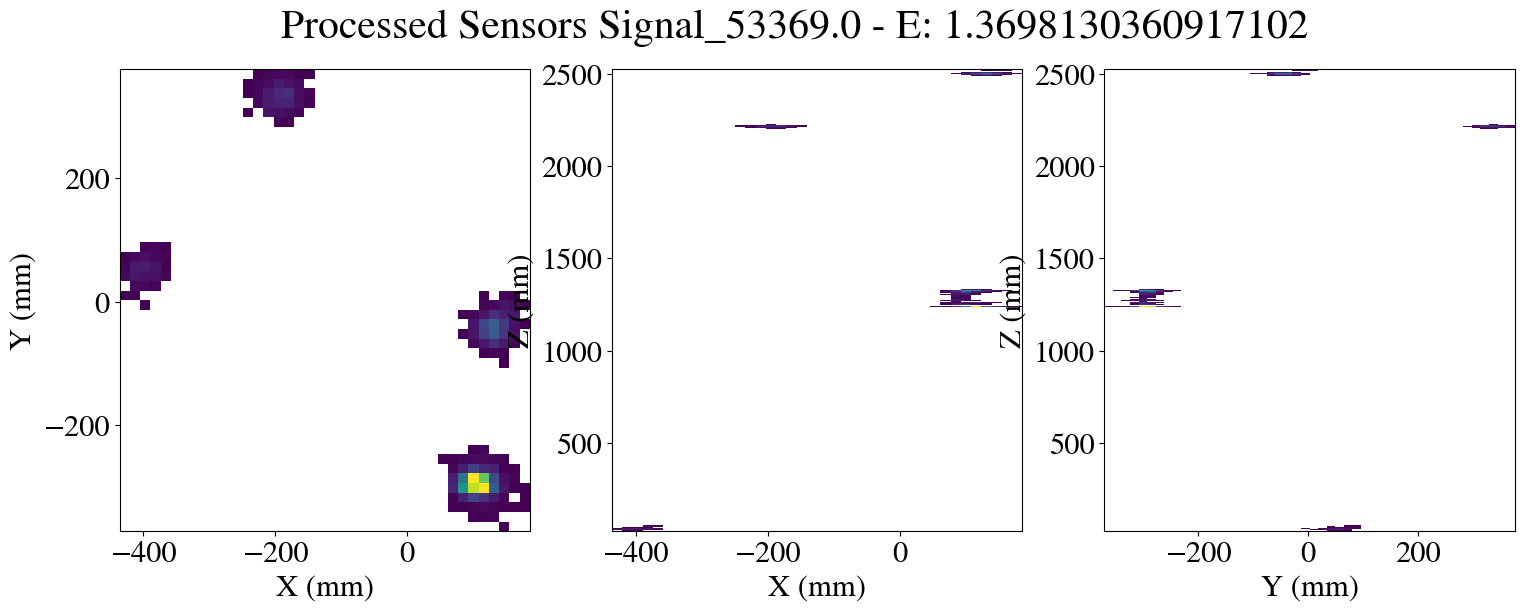

EVENT 60705.0
Total energy 1.45 MeV



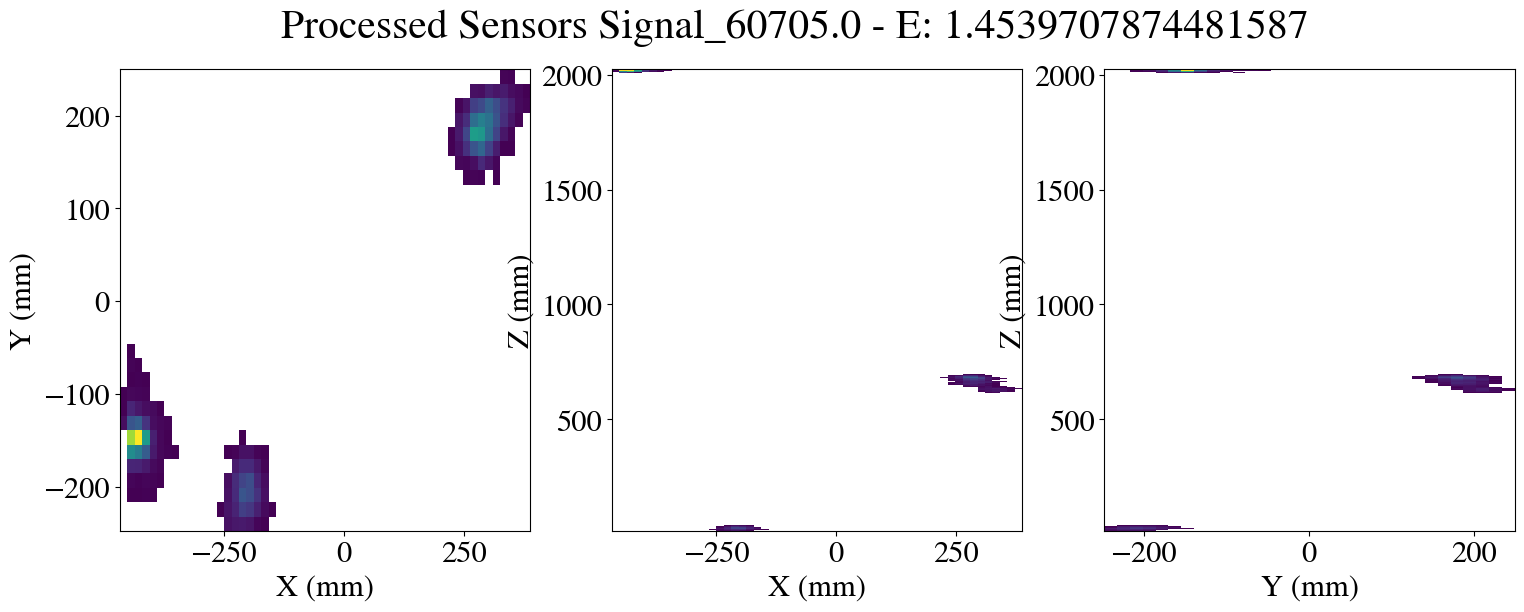

EVENT 63701.0
Total energy 1.80 MeV



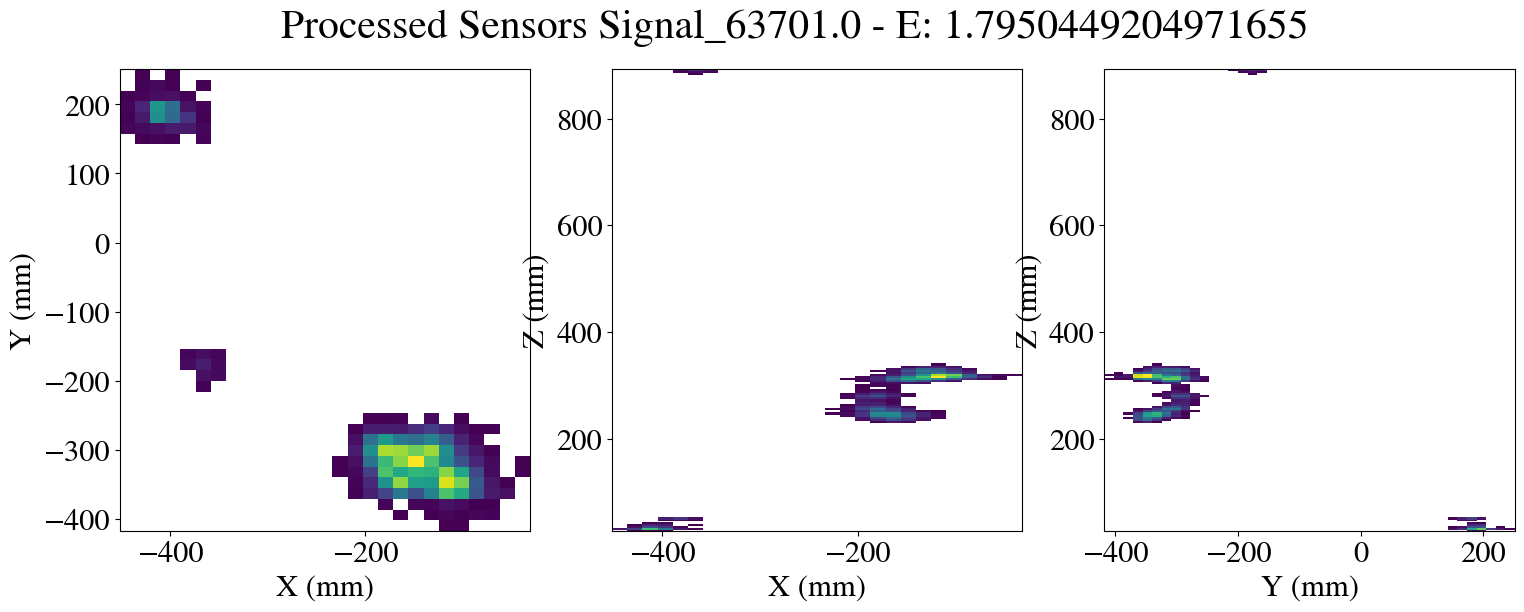

EVENT 65535.0
Total energy 1.35 MeV



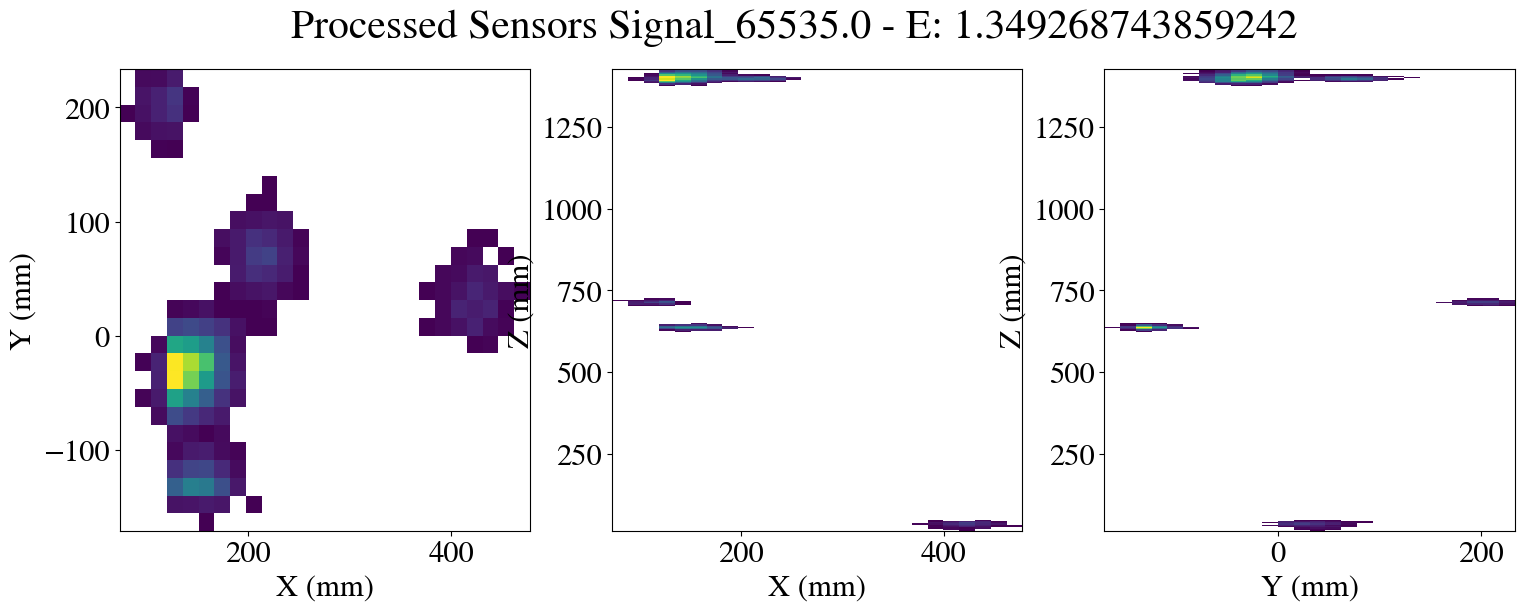

EVENT 68734.0
Total energy 1.37 MeV



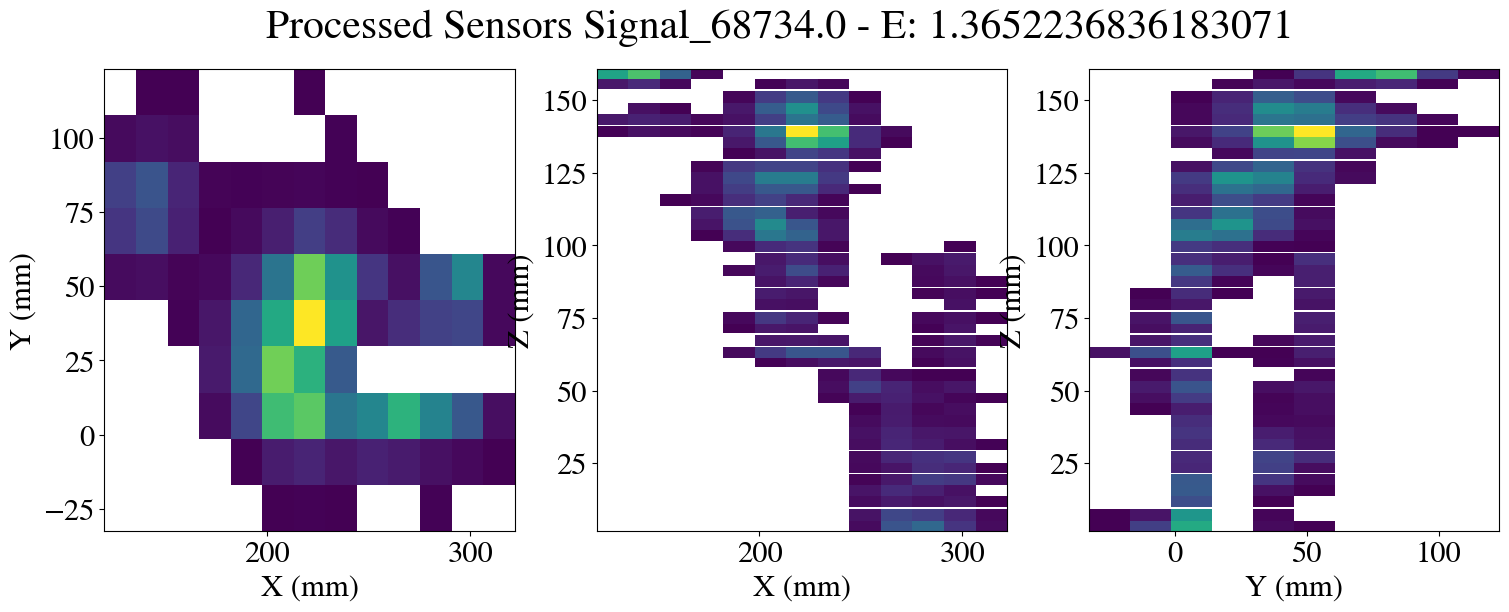

EVENT 80641.0
Total energy 1.37 MeV



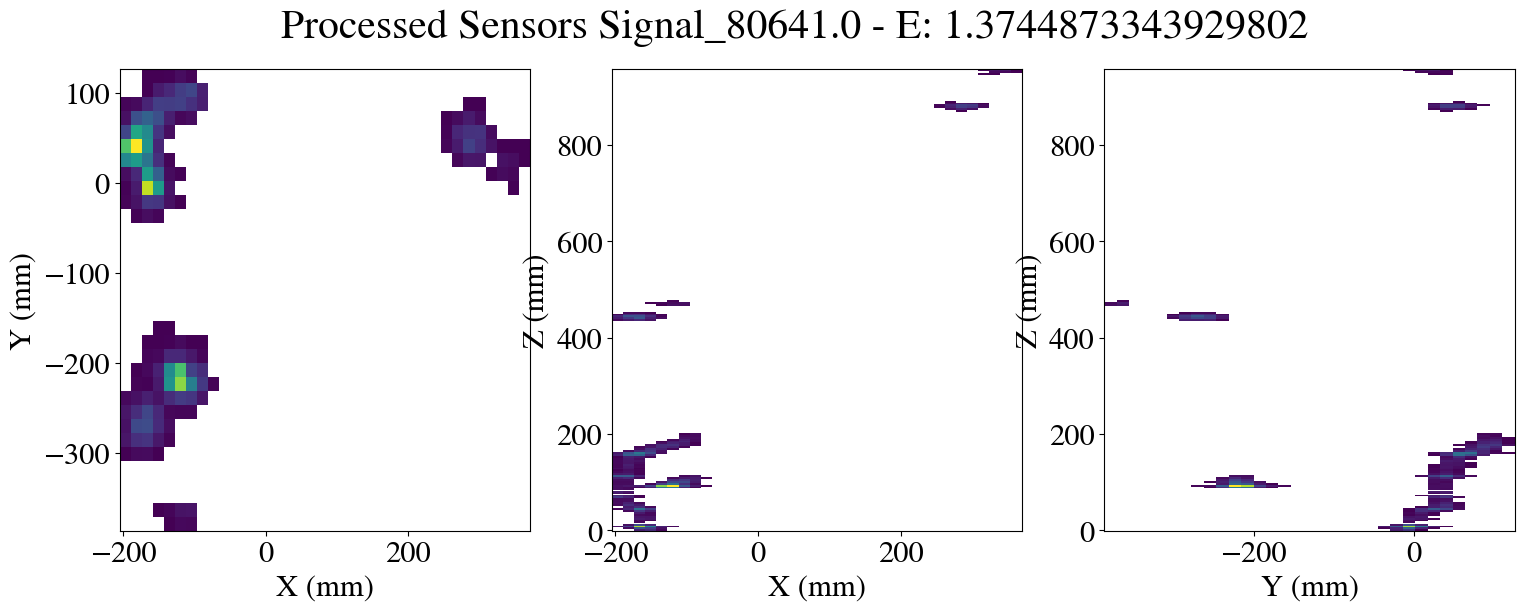

EVENT 83504.0
Total energy 1.64 MeV



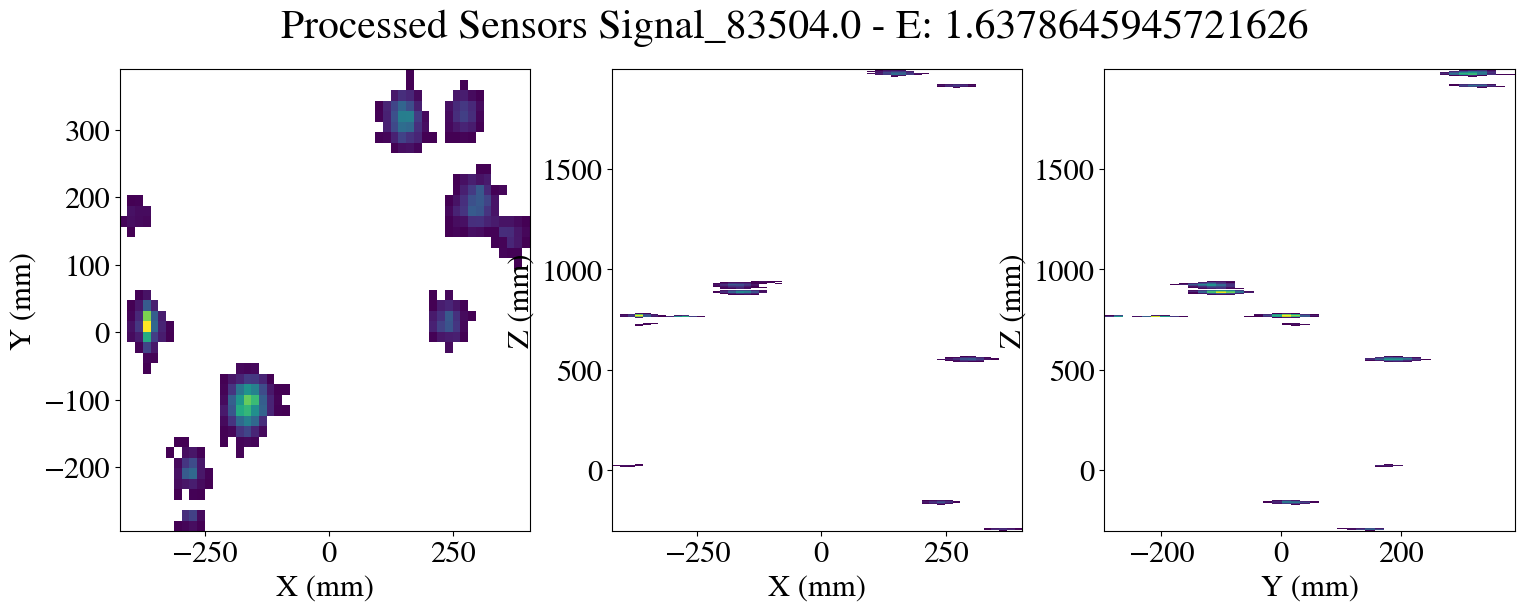

EVENT 92730.0
Total energy 1.62 MeV



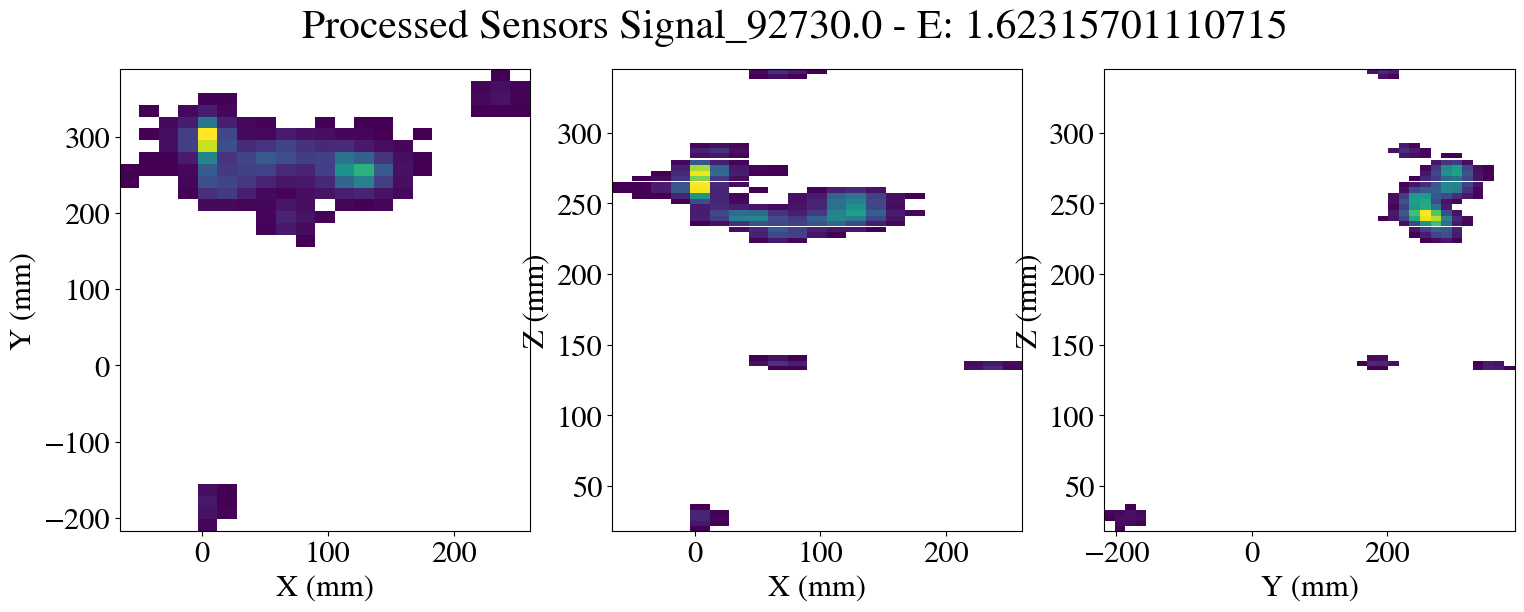

In [ ]:
stopper = 10

for i, (evt, df) in enumerate(hdst_30.groupby('event')):
    func.plotter(hdst_30, evt, cut_n_drop = False, show = True)

    if i > stopper:
        break